In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# OS 확인
if platform.system() == 'Windows':
    font_name = 'Malgun Gothic'  # 윈도우 기본 한글 폰트
elif platform.system() == 'Darwin':  # Mac
    font_name = 'AppleGothic'
else:
    font_name = 'NanumGothic'  # Linux 환경이면 설치 필요

plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지


In [16]:
import pandas as pd

# 착공 데이터 불러오기
df_housing = pd.read_csv("신규주택공급데이터/신규주택공급_병합.csv")

# 월기준 컬럼 처리
df_housing["월기준"] = pd.to_datetime(df_housing["월표기"]).dt.to_period("M")

# 총계만 필터링
df_total = df_housing[df_housing["구분"] == "총계"].copy()

# 필요한 컬럼만
df_total = df_total[["시도", "월기준", "착공호수"]]


In [17]:
# 경제활동참가율 데이터 불러오기
econ_df = pd.read_csv("경제활동인구/101_DT_1DA7014S_20250721142023.csv", encoding="cp949")

# 필터링: 경제활동참가율[%] + 성별: 계
econ_rate = econ_df[(econ_df["항목"] == "경제활동참가율[%]") & (econ_df["성별"] == "계")].copy()
econ_rate = econ_rate.rename(columns={"시도별": "시도"})

# 월별 컬럼 추출
value_vars = [col for col in econ_rate.columns if "월" in col]
econ_long = econ_rate.melt(id_vars=["시도"], value_vars=value_vars,
                           var_name="월표기", value_name="경제활동참가율")

# 월기준 정리
econ_long["월표기"] = econ_long["월표기"].str.replace(" 월", "", regex=False)
econ_long["월기준"] = pd.to_datetime(econ_long["월표기"], format="%Y.%m").dt.to_period("M")

# NaN 제거 및 정리
econ_monthly_clean = econ_long.dropna(subset=["경제활동참가율"])[["시도", "월기준", "경제활동참가율"]]


In [25]:
region_map = {
    "서울특별시": "서울",
    "부산광역시": "부산",
    "대구광역시": "대구",
    "인천광역시": "인천",
    "광주광역시": "광주",
    "대전광역시": "대전",
    "울산광역시": "울산",
    "세종특별자치시": "세종",
    "경기도": "경기",
    "강원도": "강원",
    "충청북도": "충북",
    "충청남도": "충남",
    "전라북도": "전북",
    "전라남도": "전남",
    "경상북도": "경북",
    "경상남도": "경남",
    "제주도": "제주"
}


In [26]:
# 경제활동참가율 쪽 지역명 통일
econ_monthly_clean["시도"] = econ_monthly_clean["시도"].replace(region_map)

# 착공량 쪽도 혹시 모르니 동일하게 통일
df_total["시도"] = df_total["시도"].replace(region_map)


In [27]:
# 병합
merged_df = pd.merge(df_total, econ_monthly_clean, on=["시도", "월기준"], how="inner")

# 병합 결과 시도 목록 확인
print(sorted(merged_df["시도"].unique()))


['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']


In [28]:
import statsmodels.api as sm

# 시도별 결과 저장할 리스트
correlation_results = []

for region, group in merged_df.groupby("시도"):
    # NaN 제거 (혹시 있을 경우)
    group = group.dropna(subset=["착공호수", "경제활동참가율"])

    # 상관계수
    corr = group["착공호수"].corr(group["경제활동참가율"])

    # 회귀분석
    X = sm.add_constant(group["착공호수"])
    y = group["경제활동참가율"]
    model = sm.OLS(y, X).fit()

    # 결과 저장
    correlation_results.append({
        "시도": region,
        "상관계수": round(corr, 3),
        "회귀계수": round(model.params["착공호수"], 4),
        "p값": round(model.pvalues["착공호수"], 4),
        "R제곱": round(model.rsquared, 4)
    })

# 데이터프레임으로 변환
df_corr_result = pd.DataFrame(correlation_results)

# 결과 확인
df_corr_result.sort_values("상관계수", ascending=False)


,시도,상관계수,회귀계수,p값,R제곱
14,제주,0.297,0.0008,0.0018,0.0879
3,경북,0.155,0.0002,0.1103,0.0239
4,광주,0.068,0.0001,0.4868,0.0046
11,인천,0.044,0.0000,0.6497,0.0020
16,충북,0.031,0.0001,0.7527,0.0009
8,서울,0.015,0.0000,0.8795,0.0002
6,대전,0.005,0.0000,0.9578,0.0000
12,전남,-0.042,-0.0001,0.6683,0.0017
13,전북,-0.042,-0.0001,0.6651,0.0018
15,충남,-0.043,-0.0001,0.6553,0.0019


In [29]:
# 긴 형식 변환
value_vars = [col for col in econ_rate.columns if "월" in col]
econ_long = econ_rate.melt(id_vars=["시도"], value_vars=value_vars,
                           var_name="월표기", value_name="경제활동참가율")
econ_long["월표기"] = econ_long["월표기"].str.replace(" 월", "", regex=False)
econ_long["월기준"] = pd.to_datetime(econ_long["월표기"], format="%Y.%m").dt.to_period("M")
econ_monthly_clean = econ_long.dropna(subset=["경제활동참가율"])[["시도", "월기준", "경제활동참가율"]]

# 3. 지역명 통일
region_map = {
    "서울특별시": "서울", "부산광역시": "부산", "대구광역시": "대구",
    "인천광역시": "인천", "광주광역시": "광주", "대전광역시": "대전",
    "울산광역시": "울산", "세종특별자치시": "세종", "경기도": "경기",
    "강원도": "강원", "충청북도": "충북", "충청남도": "충남",
    "전라북도": "전북", "전라남도": "전남", "경상북도": "경북",
    "경상남도": "경남", "제주도": "제주"
}
df_total["시도"] = df_total["시도"].replace(region_map)
econ_monthly_clean["시도"] = econ_monthly_clean["시도"].replace(region_map)

# 4. 병합
merged_df = pd.merge(df_total, econ_monthly_clean, on=["시도", "월기준"], how="inner")

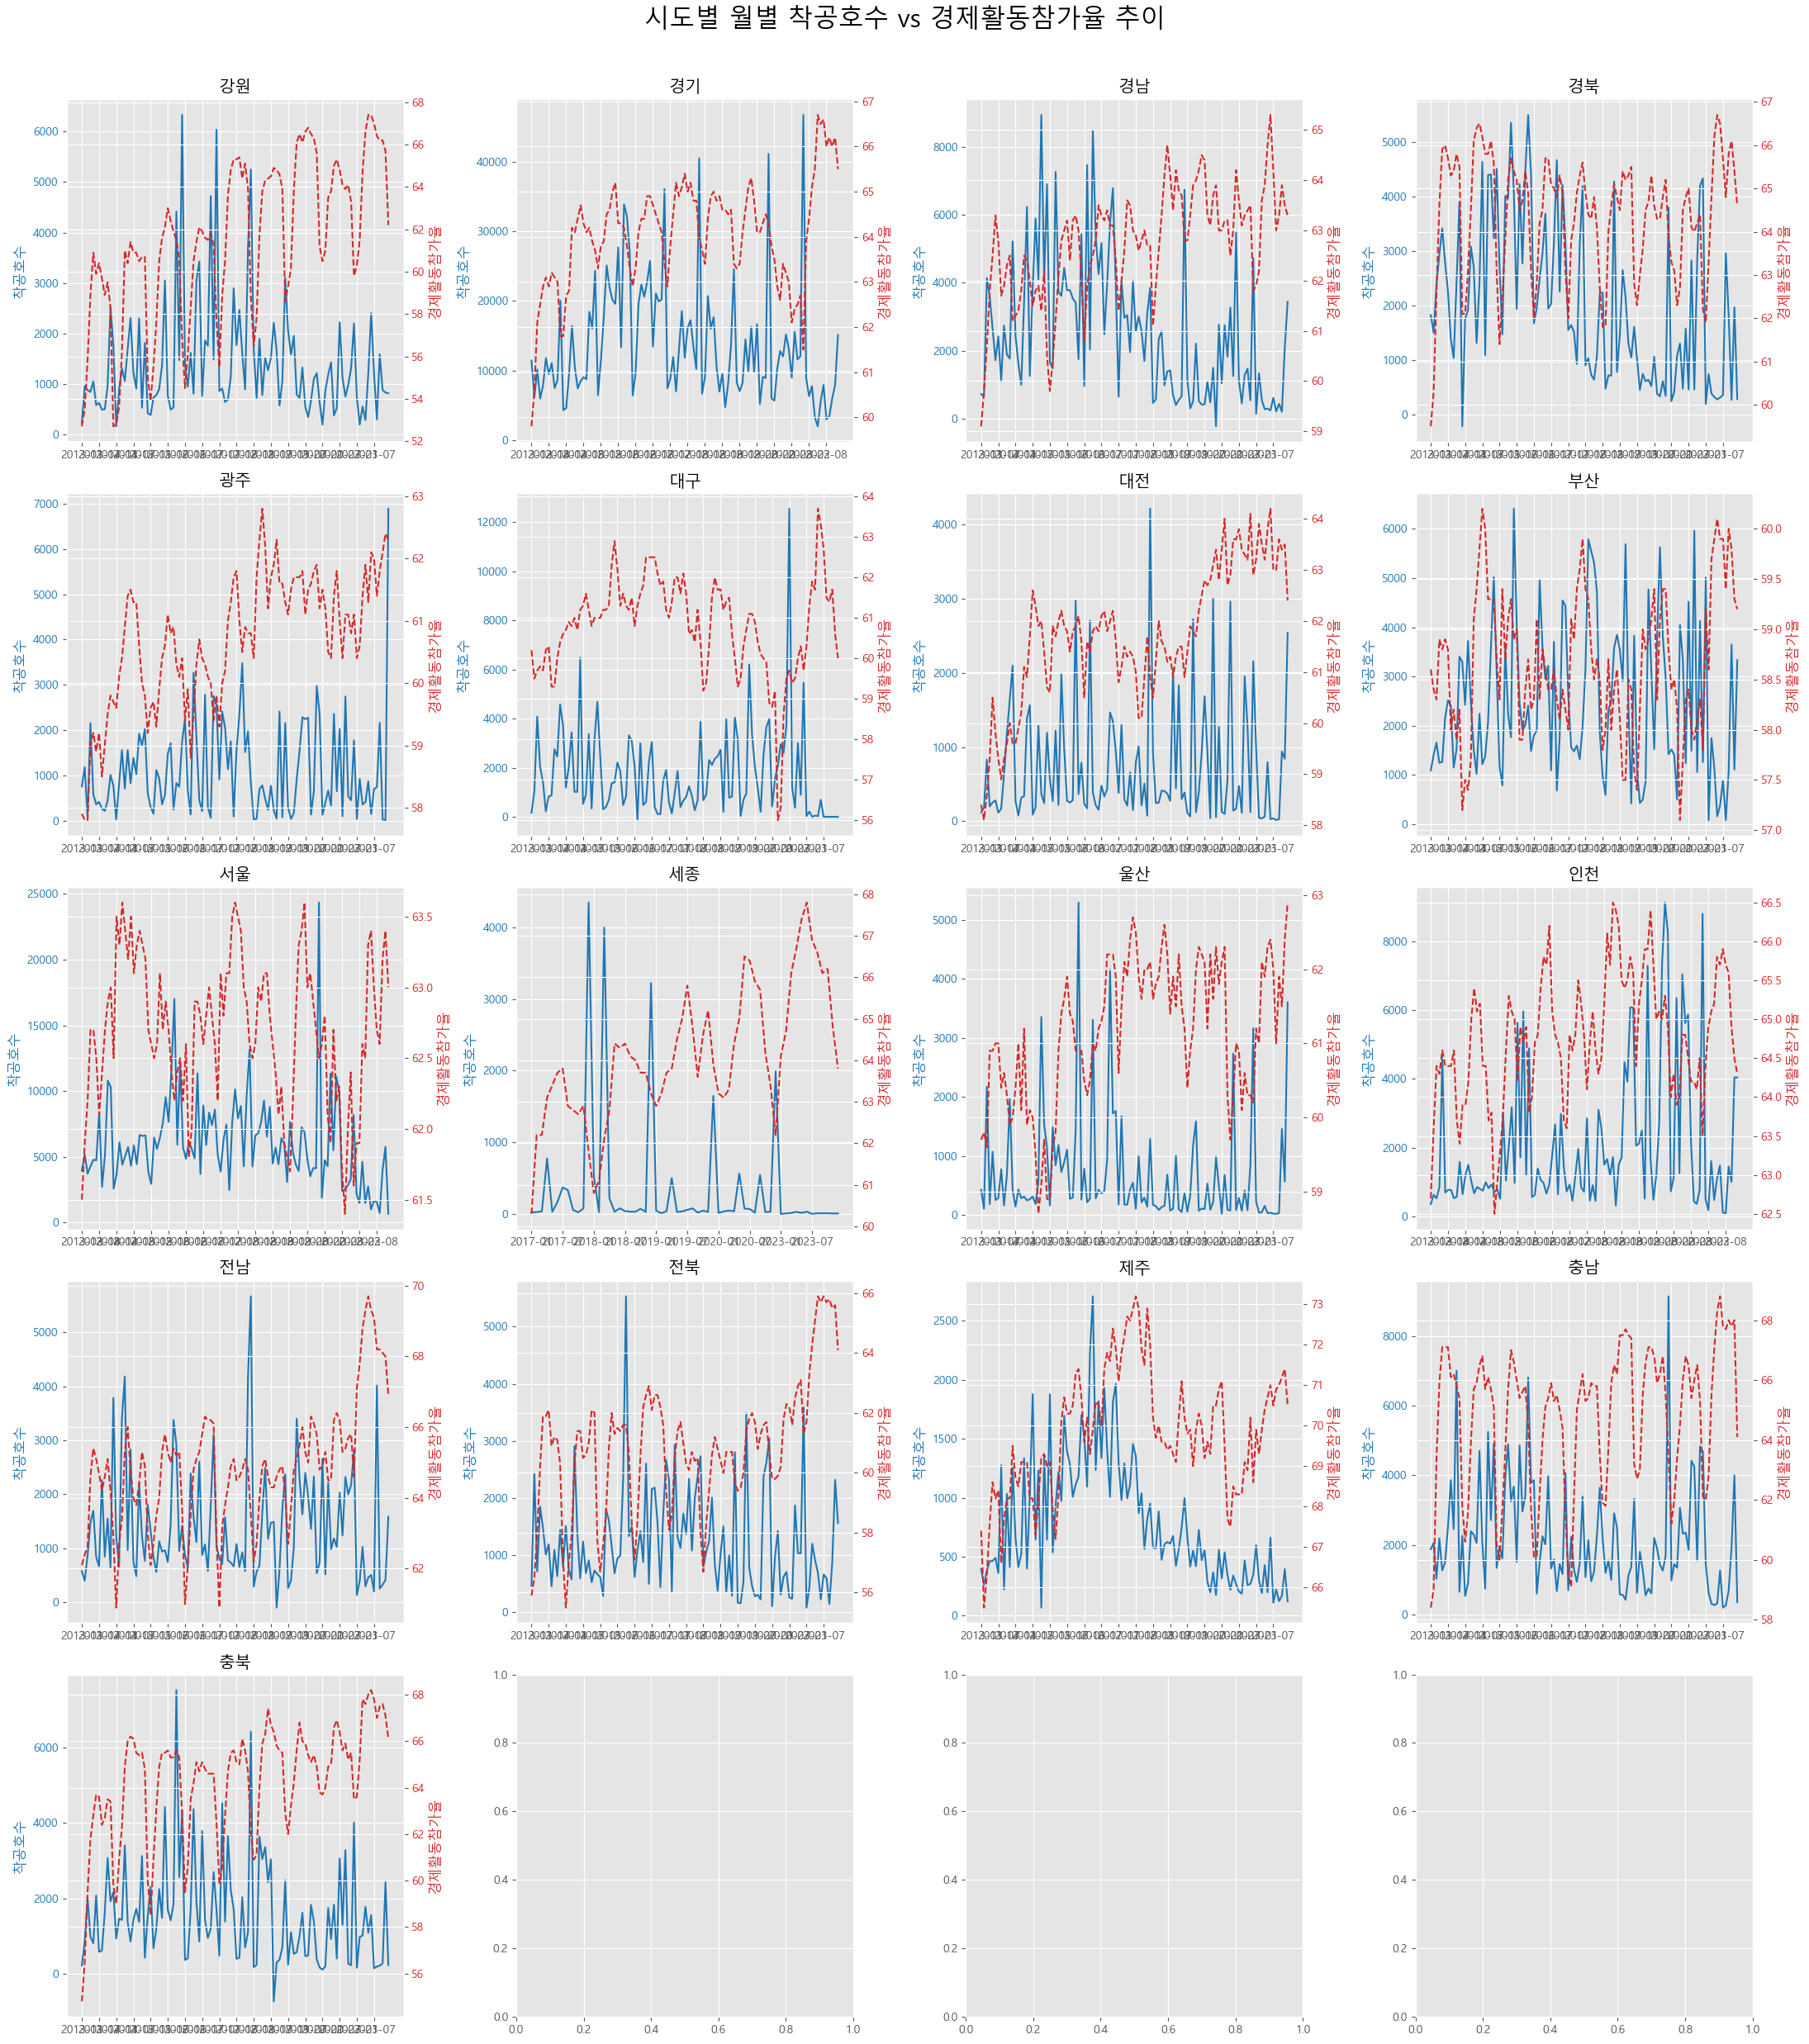

In [30]:


# 시도 목록
regions = merged_df["시도"].unique()

# 스타일 설정 및 서브플롯 생성
plt.style.use("seaborn-v0_8-muted")
fig, axs = plt.subplots(len(regions) // 4 + 1, 4, figsize=(22, 26))
axs = axs.flatten()

# 시도별 시계열 이중축 그래프
for i, region in enumerate(sorted(regions)):
    data = merged_df[merged_df["시도"] == region].sort_values("월기준")
    ax = axs[i]
    ax2 = ax.twinx()

    # 왼쪽축: 착공호수
    ax.plot(data["월기준"].astype(str), data["착공호수"], color="tab:blue", label="착공호수")
    ax.set_ylabel("착공호수", color="tab:blue")
    ax.tick_params(axis="y", labelcolor="tab:blue")

    # 오른쪽축: 경제활동참가율
    ax2.plot(data["월기준"].astype(str), data["경제활동참가율"], color="tab:red", linestyle="--", label="경제활동참가율")
    ax2.set_ylabel("경제활동참가율", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    ax.set_title(f"{region}")
    ax.set_xticks(ax.get_xticks()[::6])  # x축 라벨 간격 띄우기

fig.suptitle("시도별 월별 착공호수 vs 경제활동참가율 추이", fontsize=22)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
